In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /Users/deddy/.julia/compiled/v1.1/SatelliteTasking/HFrko.ji for SatelliteTasking [30f2e302-0ae1-11e9-1cda-0f4324764595]
└ @ Base loading.jl:1184
┌ Warning: Package SatelliteTasking does not have Gurobi in its dependencies:
│ - If you have SatelliteTasking checked out for development and have
│   added Gurobi as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with SatelliteTasking
└ Loading Gurobi into SatelliteTasking from project dependency, future warnings for SatelliteTasking are suppressed.


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 1

# Set Perturbation Values 
pos_error = 5000 # Position knowledge error [m]
vel_error = 5    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);

┌ Info: Simulating perturbed orbit 1
└ @ SatelliteTasking.Simulation /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/simulation.jl:81


 25.866753 seconds (207.98 M allocations: 9.077 GiB, 8.50% gc time)


In [3]:
# Compute True and perturbed collects

# Load test images
@time images = load_images("../data/landsat_test.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_150.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_300.json", dwell_time=5.0);
# @time images = load_images("../data/landsat_test_600.json", dwell_time=5.0);
num_images = length(images)

@time true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);
@time collects = compute_collects_by_number(true_opportunities, 10);

# Compute feasible collects
image_collects = group_image_collects(collects) # Group collects by image
num_feasible   = 0
for img in keys(image_collects)
    if length(image_collects[img]) > 0
        num_feasible += 1
    end
end
pct_feasible = num_feasible/num_images*100

println("$num_feasible out of $num_images images have collection opportunities.")

  0.287370 seconds (679.40 k allocations: 36.262 MiB, 4.97% gc time)


┌ Warning: Found 12 opportunities in window
└ @ SatelliteTasking.Analysis.CollectUncertainty /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/analysis/collect_uncertainty.jl:98
┌ Warning: Array{Float64,1}[[0.0, -1.0, -1.0], [1.0, -2.0, -3.0], [2.0, -3.0, -5.0], [1.0, 0.0, -1.0], [1.0, -3.0, -4.0], [96.0, 96.0, 0.0], [1.0, -2.0, -3.0], [0.0, -4.0, -4.0], [1.0, -4.0, -5.0], [1.0, -5.0, -6.0], [0.0, -5.0, -5.0], [1.0, -7.0, -8.0]]
└ @ SatelliteTasking.Collection /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/collection.jl:272
┌ Warning: Found 17 opportunities in window
└ @ SatelliteTasking.Analysis.CollectUncertainty /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/analysis/collect_uncertainty.jl:98
┌ Warning: Array{Float64,1}[[-7.0, -11.0, -4.0], [-6.0, -12.0, -6.0], [-6.0, -12.0, -6.0], [-6.0, -12.0, -6.0], [-5.0, -13.0, -8.0], [3.0, -20.0, -23.0], [-7.0, -12.0, -5.0], [-7.0, -12.0, -5.0], [-6.0, -13.0, -7.0], [-6.0, -12.0, -6.0], [-5.0, -15.0, -10.0], [-7.0, -12.0, -5.0], [-

┌ Warning: Found 22 opportunities in window
└ @ SatelliteTasking.Analysis.CollectUncertainty /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/analysis/collect_uncertainty.jl:98
┌ Warning: Array{Float64,1}[[-86.0, -90.0, -4.0], [-86.0, -90.0, -4.0], [-86.0, -90.0, -4.0], [-85.0, -90.0, -5.0], [-86.0, -90.0, -4.0], [-85.0, -90.0, -5.0], [-84.0, -92.0, -8.0], [-86.0, -90.0, -4.0], [-84.0, -94.0, -10.0], [-87.0, -90.0, -3.0], [-87.0, -90.0, -3.0], [-86.0, -92.0, -6.0], [9.0, 6.0, -3.0], [-90.0, -87.0, 3.0], [-88.0, -91.0, -3.0], [-88.0, -91.0, -3.0], [-93.0, -88.0, 5.0], [-90.0, -91.0, -1.0], [-90.0, -91.0, -1.0], [-82.0, -98.0, -16.0], [-87.0, -93.0, -6.0], [-89.0, -92.0, -3.0]]
└ @ SatelliteTasking.Collection /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/collection.jl:272
┌ Warning: Found 20 opportunities in window
└ @ SatelliteTasking.Analysis.CollectUncertainty /Users/deddy/Stanford/repos/SatelliteTasking.jl/src/analysis/collect_uncertainty.jl:98
┌ Warning: Array{Float64,1}[[-

 27.039757 seconds (343.28 M allocations: 35.867 GiB, 16.06% gc time)
  0.157310 seconds (394.13 k allocations: 20.375 MiB, 4.25% gc time)
125 out of 150 images have collection opportunities.


In [4]:
println(sdev_diff[1, :])
println(sdev_diff[2, :])
println(sdev_diff[3, :])
println(missing_opportunities)

[27.4826, 3.01954, 20.903, 5.6006, 19.2453, 22.3084, 0.786796, 31.1252, 20.9043, 27.9944, 25.6592, 38.6078, 20.5929, 30.7205, 39.6203, 19.2819, 24.1626, 33.8853, 26.3655, 34.5167, 30.2996, 27.7539, 6.75595, 18.7598]
[28.7212, 2.80886, 22.1718, 5.39444, 19.6977, 23.2646, 2.05866, 31.924, 22.6598, 29.6451, 31.3751, 40.2984, 20.784, 31.2299, 39.3112, 19.536, 26.2414, 33.4824, 27.2213, 47.1264, 22.8412, 34.0433, 6.01783, 28.1042]
[2.30119, 5.27062, 4.04547, 10.1522, 3.6334, 4.44537, 2.19306, 7.33254, 7.30937, 27.413, 18.6719, 7.58947, 4.14039, 28.4557, 2.33809, 26.0909, 24.6028, 43.0017, 6.03517, 40.7188, 35.6203, 29.6855, 12.3172, 22.8321]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


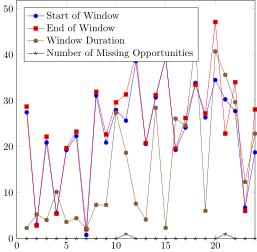

In [5]:
# Plot Differences in Opportunities
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_opportunities, legendentry="Number of Missing Opportunities")
], width="10cm", height="10cm", legendPos="north west", xmin=0, xmax=24, ymin=0)

In [ ]:
# Graph planning
@time path, reward, image_list = sp_graph_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

In [ ]:
# MILP planning
@time path, reward, image_list = sp_milp_policy(collects, Function[constraint_agility_single_axis], horizon=0.0, allow_repeats=false)

println("Total planning reward: $reward")
println("Number of images collected: $(length(image_list))/$num_images, $(length(image_list)/num_images*100)")
println("Number of feasible images collected: $(length(image_list))/$num_feasible, $(length(image_list)/num_feasible*100)")

In [ ]:
# # Mixed-Integer Programming Planning

# mcollects = deepcopy(collects)

# # Initialize MILP problem
# milp = Model(solver=GurobiSolver(Presolve=0, Heuristics=0.0)) # Cuts=0

# # Sort Collects to ensure they are in time-asecnding order
# sort!(mcollects, by = x -> x.sow)

# # constraint_list = Function[constraint_agility_single_axis]
# constraint_list = Function[constraint_agility_single_axis]

# horizon = 0
# allow_repeats = false

# # Initialize Variables
# @variable(milp, x[1:length(mcollects)], Bin)

# # Add Objective
# @objective(milp, Max, sum(col.image.reward*x[i] for (i,col) in enumerate(mcollects)))

# # Define non-repetition constraints if necessary
# if allow_repeats == false
#     # Group collects by image
#     image_collects = group_image_collects(mcollects) # Group collects by image
    
#     # Add constraints to limit one collect per image
#     for img in keys(image_collects)
#         # Only add constraints for when there is more than one possible collect
#         if length(image_collects[img]) > 1
#             @constraint(milp, sum(x[i] for i in collect(e[1] for e in image_collects[img])) <= 1)
#         end
#     end
# end

# # Add satellite model-derived constraints
# for i in 1:length(mcollects)
#     for j in  i:length(mcollects)
#         # Since all constraints are reciprocal they only need to be checked in one direction
#         col_start = mcollects[i]
#         col_end   = mcollects[j]
        
#         # Skip adding constraints if a planning horizon is being used
#         if horizon > 0 && col_end.sow > (col_start.eow + horizon)
#             # Condition to exit early is only considering transitions within a certain horizon may be invalid
#             continue
#         end

#         if col_start == col_end || col_start.image == col_end.image || col_start.opportunity == col_end.opportunity || j < i
#             # Skip if the same opportunity, or same image because this is already covered
#             continue
#         else
#             # Transition is default valid
#             valid_transition = true
            
#             # Only evaluate transitions if time constraint doesn't matter
#             for constraint in constraint_list
#                 # Use logical and to evaulate path feasibility
#                 # Because this is a binary comparison (independent of time), and constraints are nominally
#                 # evaluated with start dependent on the end, we only add a constraint if neither transition is valid
#                 # Otherwise the problem would be over constrained just due to the final opportunity not
#                 # being able to take images before the current
#                 valid_transition = valid_transition && (constraint(col_start, col_end) || constraint(col_end, col_start))
                
#                 # Add constraint as soon as invalid to short-circuit additional evaluations
#                 if !valid_transition
#                     # Boolean logic constraint permitting taking start opportunity, but
#                     @constraint(milp, x[i] + x[j] <= 1)
#                     # println("Invalid due to agility")
#                     continue
#                 end
#             end
#         end
#     end
# end

# # println(milp);

In [ ]:
# status = solve(milp);

In [ ]:
# # count = 0
# # taken = []
# # for i in 1:length(mcollects)
# #     if getvalue(x[i]) != 0.0
# # #         println("x[$i] = $(getvalue(x[i])), Collect: $(string(mcollects[i]))")
# #         count += 1
# #         push!(taken, i)
# #     end
# # end

# # println("Count: $count")
# # println(taken)
# # feasible = []
# # for i in 1:length(taken)-1
# #     push!(feasible, constraint_agility_single_axis(mcollects[taken[i]], mcollects[taken[i+1]]))
# # end

# # println(feasible)

# max_col = 0
# img_max = nothing
# for img in keys(image_collects)
#     if length(image_collects[img]) > max_col
#         max_col = length(image_collects[img])
#         img_max = img
#     end
# end

# println(max_col)
# println(img_max)
# for col in image_collects[img_max]
#     println(col)
# end